<a href="https://colab.research.google.com/github/MizanMustakim/Big_data_movie_project/blob/main/Big_data_assignment_project_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection work

**Import the libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import urllib

**Collecting DATA_1**

In [3]:
url = "https://www.worldometers.info/coronavirus/?utm_campaign=homeAdvegas1?%22%20%5Cl%22countries"
data = requests.get(url)
soup = BeautifulSoup(data.text,'html5lib')

In [4]:
covid_dict = {}
div = soup.find_all("div", {"id": "ExplorerContainer"})
for i in div:
  content_div = i.find("div",{"class":"tableTab"})
  covid_dict[i.find("h1").text.replace(":","").strip()] = content_div.find("span").text.strip()

In [5]:
tables = soup.find_all('table')
table_header = tables[0].find_all('th')
table_head = []
for i in range(15):
  if i != 0:
    table_head.append(table_header[i].text.replace("\n","").replace("\xa0",""))
print(table_head)

['Country,Other', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', 'Population']


In [6]:
Covid_data = pd.DataFrame(columns=table_head)
for row in tables[0].tbody.find_all('tr'):
  col = row.find_all('td')
  if (col != []):
    country = col[1].text.strip()
    totalCases = col[2].text.strip()
    newCases = col[3].text.strip()
    totalDeaths = col[4].text.strip()
    newDeaths = col[5].text.strip()
    totalRecovered = col[6].text.strip()
    newRecovered = col[7].text.strip()
    activeCases = col[8].text.strip()
    serious = col[9].text.strip()
    totalCases_per_m = col[10].text.strip()
    deaths = col[11].text.strip()
    totalTests = col[12].text.strip()
    tests_per_m = col[13].text.strip()
    population = col[14].text.strip()
    Covid_data = Covid_data.append({"Country,Other":country,"TotalCases":totalCases,"NewCases":newCases,
                                    "TotalDeaths":totalDeaths,"NewDeaths":newDeaths,"TotalRecovered":totalRecovered,
                                    "NewRecovered":newRecovered,"ActiveCases":activeCases,"Serious,Critical":serious,
                                    "TotCases/1M pop":totalCases_per_m,"Deaths/1M pop":deaths,"TotalTests":totalTests,
                                    "Tests/1M pop":tests_per_m,"Population":population},ignore_index=True)

In [7]:
Covid_data.drop(Covid_data.index[:7],inplace=True)
Covid_data.to_csv("Covid_data.csv",index=False)

**Collecting DATA_2**

In [8]:
!wget --no-check-certificate \
  https://covid.ourworldindata.org/data/owid-covid-data.csv #\
#   -O /content/owid-covid-data.csv

--2022-01-07 14:00:33--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.138, 104.21.233.137, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv’

owid-covid-data.csv     [    <=>             ]  40.91M  65.1MB/s    in 0.6s    

2022-01-07 14:00:34 (65.1 MB/s) - ‘owid-covid-data.csv’ saved [42902343]



# Data Processing Work

**Install PySpark**

In [9]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 44 kB/s 
     |████████████████████████████████| 198 kB 50.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=059f95d0edf898924de30180156691af1d2b0c89b73534e83209cf91e1a10078
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


**Importing Libraries**

In [10]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DecimalType, LongType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains
from pyspark.sql.functions import regexp_replace, regexp_extract, col
from pyspark.sql.types import IntegerType

**Pre-processing DATA with PySpark**

**vaccine Data**

Reading the vaccination csv data in **PySpark**

In [11]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/owid-covid-data.csv'
sdfData = spark.read.csv(df, header=True, sep=",").cache()
sdfData = sdfData.withColumnRenamed("location", "Country")

sdfData.show(10)

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+---------+-----------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

Checking the Schema of the created dataframe

In [12]:
sdfData.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: string (nullable = true)
 |-- new_cases: string (nullable = true)
 |-- new_cases_smoothed: string (nullable = true)
 |-- total_deaths: string (nullable = true)
 |-- new_deaths: string (nullable = true)
 |-- new_deaths_smoothed: string (nullable = true)
 |-- total_cases_per_million: string (nullable = true)
 |-- new_cases_per_million: string (nullable = true)
 |-- new_cases_smoothed_per_million: string (nullable = true)
 |-- total_deaths_per_million: string (nullable = true)
 |-- new_deaths_per_million: string (nullable = true)
 |-- new_deaths_smoothed_per_million: string (nullable = true)
 |-- reproduction_rate: string (nullable = true)
 |-- icu_patients: string (nullable = true)
 |-- icu_patients_per_million: string (nullable = true)
 |-- hosp_patients: string (nullable = true)
 |-- hosp_patients_per_million:

Separate the new_vaccination info of the day before the current day from data table.

In [13]:
from datetime import date
import datetime

In [14]:
#transform
sdfData.registerTempTable("vaccine")

today = date.today() - datetime.timedelta(days=1)


vaccine_data = spark.sql('SELECT Country, continent,\
                          SUM(cast(people_vaccinated as int)) as Total_vaccinated\
                          FROM vaccine \
                          WHERE continent <> "null" \
                          GROUP BY Country, continent')

population_data = spark.sql('SELECT Country, population \
                          FROM vaccine \
                          WHERE date = "{}" AND continent <> "null"'.format(today.strftime("%Y-%m-%d")))


vaccine_data = vaccine_data.join(population_data, ["Country"], how="outer")

vaccine_data.show()

+-------------------+-------------+----------------+-----------+
|            Country|    continent|Total_vaccinated| population|
+-------------------+-------------+----------------+-----------+
|        Afghanistan|         Asia|        19368570| 39835428.0|
|            Albania|       Europe|       125081646|  2872934.0|
|            Algeria|       Africa|       106450533| 44616626.0|
|            Andorra|       Europe|          909138|    77354.0|
|             Angola|       Africa|       120976841| 33933611.0|
|           Anguilla|North America|          271433|    15125.0|
|Antigua and Barbuda|North America|         3340114|    98728.0|
|          Argentina|South America|      6099070777| 45605823.0|
|            Armenia|         Asia|        11360818|  2968128.0|
|              Aruba|North America|        15512497|   107195.0|
|          Australia|      Oceania|      3147217956| 25788217.0|
|            Austria|       Europe|      1425423963|  9043072.0|
|         Azerbaijan|    

Checking the schema of the new DataFrame

In [15]:
vaccine_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- Total_vaccinated: long (nullable = true)
 |-- population: string (nullable = true)



Converting the string data type into the integer data type of new_vaccination data and population data.

In [16]:
data = ["Total_vaccinated", "population"]

for i in data:
    vaccine_data = vaccine_data.withColumn(i, vaccine_data[i].cast(LongType()))

Now again check the schema, and get the difference.

In [17]:
vaccine_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- Total_vaccinated: long (nullable = true)
 |-- population: long (nullable = true)



Now replace the null values with zero(0)

In [18]:
vaccine_data = vaccine_data.fillna(value=0)
vaccine_data.show()

+-------------------+-------------+----------------+----------+
|            Country|    continent|Total_vaccinated|population|
+-------------------+-------------+----------------+----------+
|        Afghanistan|         Asia|        19368570|  39835428|
|            Albania|       Europe|       125081646|   2872934|
|            Algeria|       Africa|       106450533|  44616626|
|            Andorra|       Europe|          909138|     77354|
|             Angola|       Africa|       120976841|  33933611|
|           Anguilla|North America|          271433|     15125|
|Antigua and Barbuda|North America|         3340114|     98728|
|          Argentina|South America|      6099070777|  45605823|
|            Armenia|         Asia|        11360818|   2968128|
|              Aruba|North America|        15512497|    107195|
|          Australia|      Oceania|      3147217956|  25788217|
|            Austria|       Europe|      1425423963|   9043072|
|         Azerbaijan|         Asia|     

Checking the DataFrame shape

In [19]:
print((vaccine_data.count(), len(vaccine_data.columns)))

(225, 4)


Storing the pre-processed data into the data warehouse.

In [20]:
vaccine_data.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("vaccine_data.csv")

# Covid Data

Load the csv file of covid data in **PySpark**

In [21]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/Covid_data.csv'
covid_dfData = spark.read.csv(df, header=True, sep=",").cache()

covid_dfData.show(4)

+-------------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|Country,Other| TotalCases|NewCases|TotalDeaths|NewDeaths|TotalRecovered|NewRecovered|ActiveCases|Serious,Critical|TotCases/1M pop|Deaths/1M pop| TotalTests|Tests/1M pop|   Population|
+-------------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|        World|301,121,258|+356,293|  5,492,061|   +2,206|   257,728,113|    +198,913| 37,901,084|          92,107|         38,631|        704.6|       null|        null|         null|
|          USA| 59,564,116|    null|    855,843|     null|    42,089,198|        null| 16,619,075|          21,467|        178,368|        2,563|829,437,395|   2,483,791|  333,940,077|
|        India| 35,226,386|    null|    483,178|     null|    34,371,845|  

Lets change the Column name from "Country,other" to "Country"

In [22]:
covid_dfData = covid_dfData.withColumnRenamed("Country,Other", "Country")
covid_dfData = covid_dfData.withColumnRenamed("Serious,Critical", "Critical_patient")
covid_dfData.show(4)

+-------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|Country| TotalCases|NewCases|TotalDeaths|NewDeaths|TotalRecovered|NewRecovered|ActiveCases|Critical_patient|TotCases/1M pop|Deaths/1M pop| TotalTests|Tests/1M pop|   Population|
+-------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|  World|301,121,258|+356,293|  5,492,061|   +2,206|   257,728,113|    +198,913| 37,901,084|          92,107|         38,631|        704.6|       null|        null|         null|
|    USA| 59,564,116|    null|    855,843|     null|    42,089,198|        null| 16,619,075|          21,467|        178,368|        2,563|829,437,395|   2,483,791|  333,940,077|
|  India| 35,226,386|    null|    483,178|     null|    34,371,845|        null|    371,363|           8,

Separate the columns named "Country", "TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "TotalRecovered" from the data frame. And convert them from string data type into integer data type, excxept the column named "Country".

In [23]:
covid_selected_data = covid_dfData["Country", "TotalCases", "NewCases", "NewDeaths", "Critical_patient", "TotalDeaths", "TotalRecovered"]

In [24]:
data = ["TotalCases", "NewCases", "NewDeaths", "Critical_patient", "TotalDeaths", "TotalRecovered"]

for i in data:
    covid_selected_data = covid_selected_data.withColumn(i, regexp_replace(i, ',', ''))
    covid_selected_data = covid_selected_data.withColumn(i, covid_selected_data[i].cast(IntegerType()))

In [25]:
covid_selected_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: integer (nullable = true)
 |-- NewCases: integer (nullable = true)
 |-- NewDeaths: integer (nullable = true)
 |-- Critical_patient: integer (nullable = true)
 |-- TotalDeaths: integer (nullable = true)
 |-- TotalRecovered: integer (nullable = true)



In [26]:
covid_selected_data.show()

+------------+----------+--------+---------+----------------+-----------+--------------+
|     Country|TotalCases|NewCases|NewDeaths|Critical_patient|TotalDeaths|TotalRecovered|
+------------+----------+--------+---------+----------------+-----------+--------------+
|       World| 301121258|  356293|     2206|           92107|    5492061|     257728113|
|         USA|  59564116|    null|     null|           21467|     855843|      42089198|
|       India|  35226386|    null|     null|            8944|     483178|      34371845|
|      Brazil|  22395322|    null|     null|            8318|     619730|      21567845|
|          UK|  14015065|    null|     null|             875|     149515|      10620728|
|      France|  11183238|    null|     null|            3333|     125013|       8393827|
|      Russia|  10618035|   16735|      787|            2300|     314604|       9645712|
|      Turkey|   9787274|    null|     null|            1128|      83231|       9217669|
|     Germany|   7399

Fill the null value with zero(0).

In [27]:
covid_selected_data = covid_selected_data.fillna(value=0)
covid_selected_data.show(10)

+-------+----------+--------+---------+----------------+-----------+--------------+
|Country|TotalCases|NewCases|NewDeaths|Critical_patient|TotalDeaths|TotalRecovered|
+-------+----------+--------+---------+----------------+-----------+--------------+
|  World| 301121258|  356293|     2206|           92107|    5492061|     257728113|
|    USA|  59564116|       0|        0|           21467|     855843|      42089198|
|  India|  35226386|       0|        0|            8944|     483178|      34371845|
| Brazil|  22395322|       0|        0|            8318|     619730|      21567845|
|     UK|  14015065|       0|        0|             875|     149515|      10620728|
| France|  11183238|       0|        0|            3333|     125013|       8393827|
| Russia|  10618035|   16735|      787|            2300|     314604|       9645712|
| Turkey|   9787274|       0|        0|            1128|      83231|       9217669|
|Germany|   7399003|       0|        0|            4636|     114207|       6

Storing the pre-processed data into the data warehouse.

In [28]:
covid_selected_data.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("covid_data.csv")

# Now concatening these two datasets what we have pre-processed above. And process them.

In [29]:
final_df = covid_selected_data.join(vaccine_data, ["Country"], how="outer")
final_df.show()

+-------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|            Country|TotalCases|NewCases|NewDeaths|Critical_patient|TotalDeaths|TotalRecovered|    continent|Total_vaccinated|population|
+-------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|        Afghanistan|    158300|      21|        0|            1124|       7368|        145771|         Asia|        19368570|  39835428|
|            Albania|    214941|       0|        0|              23|       3233|        202386|       Europe|       125081646|   2872934|
|            Algeria|    220825|       0|        0|              34|       6318|        151604|       Africa|       106450533|  44616626|
|            Andorra|     25289|       0|        0|              31|        141|         21511|       Europe|          909138|     77354|
|             Angola|     87625|  

Checking the final dataframe's size

In [30]:
print((final_df.count(), len(final_df.columns)))

(254, 10)


Dropping all NA values from the column named "Population", so that we can get all country data except other data.

In [31]:
final_df = final_df.na.drop(subset=["population"])
final_df.show()

+-------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|            Country|TotalCases|NewCases|NewDeaths|Critical_patient|TotalDeaths|TotalRecovered|    continent|Total_vaccinated|population|
+-------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|        Afghanistan|    158300|      21|        0|            1124|       7368|        145771|         Asia|        19368570|  39835428|
|            Albania|    214941|       0|        0|              23|       3233|        202386|       Europe|       125081646|   2872934|
|            Algeria|    220825|       0|        0|              34|       6318|        151604|       Africa|       106450533|  44616626|
|            Andorra|     25289|       0|        0|              31|        141|         21511|       Europe|          909138|     77354|
|             Angola|     87625|  

Now checking again the dataframe's size

In [32]:
print((final_df.count(), len(final_df.columns)))

(225, 10)


The following code is to get the list data of any particular column. Here we tried to get the distinct data of continent column.

In [33]:
continent = final_df.select("continent").distinct().rdd.flatMap(list).collect()
print("Total number of continent: ",len(continent))
print(continent)

Total number of continent:  6
['Europe', 'Africa', 'North America', 'South America', 'Oceania', 'Asia']


Getting the distinct data of country column.

In [34]:
country = final_df.select("country").distinct().rdd.flatMap(list).collect()
print("Total number of country: ",len(country))
print(country)

Total number of country:  225
['Chad', 'Anguilla', 'Paraguay', 'Russia', 'Macao', 'Yemen', 'Senegal', 'Sweden', 'Tokelau', 'Kiribati', 'Guyana', 'Eritrea', 'Jersey', 'Philippines', 'Djibouti', 'Tonga', 'Malaysia', 'Singapore', 'Fiji', 'Turkey', 'Malawi', 'Iraq', 'Sint Maarten (Dutch part)', 'Germany', 'Comoros', 'Afghanistan', 'Cambodia', 'Jordan', 'Maldives', 'Rwanda', 'Saint Helena', 'Sudan', 'Palau', 'France', 'Turks and Caicos Islands', 'Greece', 'Kosovo', 'Sri Lanka', 'Montserrat', 'British Virgin Islands', 'Dominica', 'Taiwan', 'Algeria', 'Equatorial Guinea', 'Togo', 'Slovakia', 'Argentina', 'Angola', 'Belgium', 'Vatican', 'San Marino', 'Ecuador', 'Qatar', 'Bonaire Sint Eustatius and Saba', 'Lesotho', 'Albania', 'Madagascar', 'Finland', 'New Caledonia', 'Ghana', 'Myanmar', 'Nicaragua', 'Guernsey', 'Benin', 'Peru', 'Sierra Leone', 'Bahamas', 'China', 'Curacao', 'India', 'United States', 'Belarus', 'Kuwait', 'Malta', 'Sao Tome and Principe', 'Marshall Islands', 'Somalia', 'Tuvalu',

Save the data to the data warehouse

In [35]:
final_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("final_df_data.csv")

# Visualising the Data

Import libraries

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

Load the final dataset from data warehouse

In [37]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/final_df_data.csv'
final_data = spark.read.csv(df, header=True, sep=",").cache()

final_data.show(40)

+--------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|             Country|TotalCases|NewCases|NewDeaths|Critical_patient|TotalDeaths|TotalRecovered|    continent|Total_vaccinated|population|
+--------------------+----------+--------+---------+----------------+-----------+--------------+-------------+----------------+----------+
|         Afghanistan|    158300|      21|        0|            1124|       7368|        145771|         Asia|        19368570|  39835428|
|             Albania|    214941|       0|        0|              23|       3233|        202386|       Europe|       125081646|   2872934|
|             Algeria|    220825|       0|        0|              34|       6318|        151604|       Africa|       106450533|  44616626|
|             Andorra|     25289|       0|        0|              31|        141|         21511|       Europe|          909138|     77354|
|              Angola|     

Checking if there are any inetger column in string format.

In [38]:
final_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: string (nullable = true)
 |-- NewCases: string (nullable = true)
 |-- NewDeaths: string (nullable = true)
 |-- Critical_patient: string (nullable = true)
 |-- TotalDeaths: string (nullable = true)
 |-- TotalRecovered: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- Total_vaccinated: string (nullable = true)
 |-- population: string (nullable = true)



Since there are some string columns yet. So first convert them into integer type, and then replace null value with 0.

In [39]:
data = ["TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "Critical_patient", "TotalRecovered", "Total_vaccinated", "population"]

for i in data:
    final_data = final_data.withColumn(i, final_data[i].cast(LongType()))

In [40]:
final_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: long (nullable = true)
 |-- NewCases: long (nullable = true)
 |-- NewDeaths: long (nullable = true)
 |-- Critical_patient: long (nullable = true)
 |-- TotalDeaths: long (nullable = true)
 |-- TotalRecovered: long (nullable = true)
 |-- continent: string (nullable = true)
 |-- Total_vaccinated: long (nullable = true)
 |-- population: long (nullable = true)



In [41]:
final_data = final_data.na.fill(value=0)

***Total Death analysis on different continent.***

Separate them from the data table.

In [42]:
final_data.registerTempTable("final_data")
c = spark.sql("SELECT continent, SUM(TotalDeaths) as TotalDeaths, \
              SUM(Total_vaccinated) as Total_vaccinated, \
              SUM(TotalRecovered) as TotalRecovered \
              FROM final_data \
              GROUP BY continent")
c.show()

+-------------+-----------+----------------+--------------+
|    continent|TotalDeaths|Total_vaccinated|TotalRecovered|
+-------------+-----------+----------------+--------------+
|       Europe|    1397057|     88475395831|      66446518|
|       Africa|     228113|      8536119870|       8666809|
|North America|     397396|     82466398616|       8936124|
|South America|    1193483|     49809026700|      36094858|
|      Oceania|       4592|      3746082812|        464910|
|         Asia|    1252343|    230977985693|      81010625|
+-------------+-----------+----------------+--------------+



Storing the data into the variables, so that later we can plot them.

In [43]:
total_death = c.select("TotalDeaths").rdd.flatMap(list).collect()
continent = c.select("continent").rdd.flatMap(list).collect()
total_vaccinations = c.select("Total_vaccinated").rdd.flatMap(list).collect()
TotalRecovered = c.select("TotalRecovered").rdd.flatMap(list).collect()

Visualizing the death rate on every region by Pie Chart.

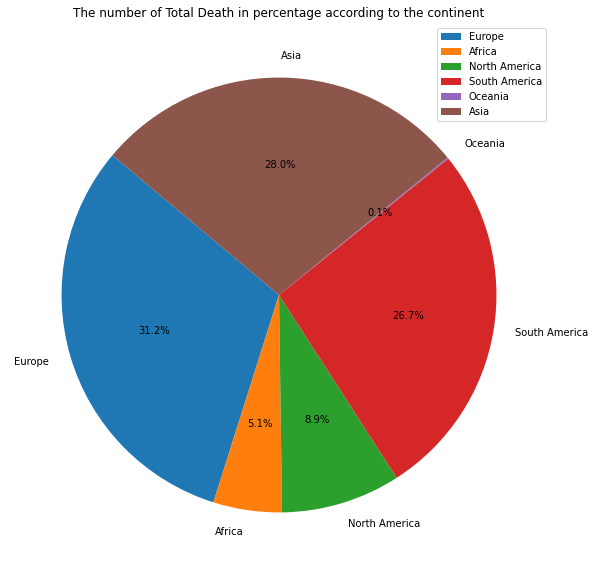

In [44]:
fig = plt.figure(figsize=(12, 10))
plt.pie(total_death, autopct='%1.1f%%', startangle=140, radius=1, labels=continent)
plt.title("The number of Total Death in percentage according to the continent")
plt.legend()
plt.show()

Visualizing the vaccination rate on every region in Bar plot.

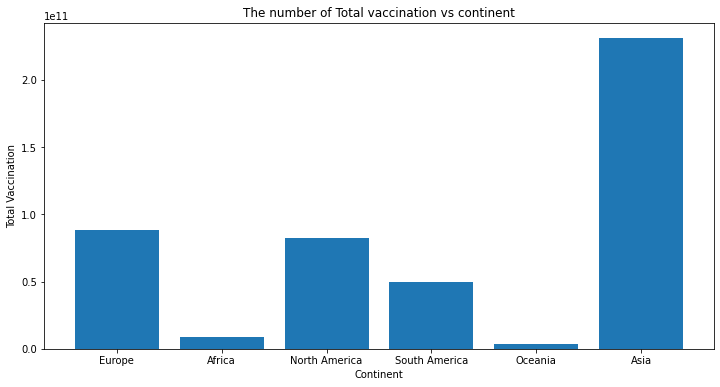

In [45]:
fig = plt.figure(figsize=(12, 6))

plt.bar(continent,total_vaccinations)
plt.xlabel("Continent")
plt.ylabel("Total Vaccination")
plt.title("The number of Total vaccination vs continent")
plt.show()

A graphical presentation of the Covid-19 scenario on every region.

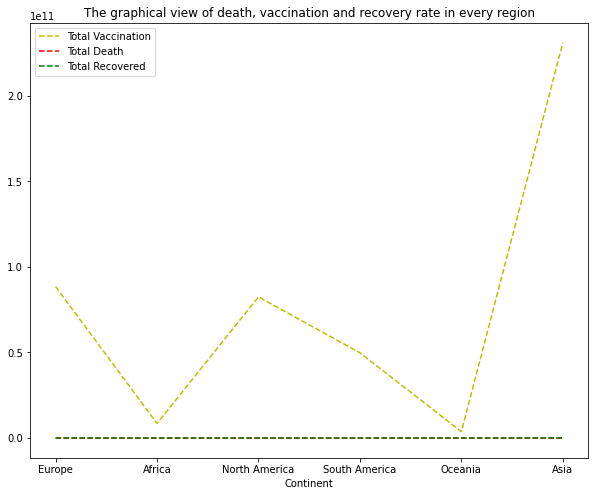

In [46]:
fig = plt.figure(figsize=(10, 8))

plt.plot(continent,total_vaccinations, "y--", label="Total Vaccination")
plt.plot(continent,total_death, "r--", label="Total Death")
plt.plot(continent,TotalRecovered, "g--", label="Total Recovered")
plt.xlabel("Continent")
plt.legend()
plt.title("The graphical view of death, vaccination and recovery rate in every region")
plt.show()

**Machine Learning Model**

In [47]:
import tensorflow as tf
from keras import backend
from keras.callbacks import EarlyStopping

In [49]:
train_data = pd.read_csv("/content/final_df_data.csv/part-00000-aed51b21-caf5-4e7e-aa03-7ceb8fc17ac4-c000.csv")
train_data.head()

,Country,TotalCases,NewCases,NewDeaths,Critical_patient,TotalDeaths,TotalRecovered,continent,Total_vaccinated,population
0,Afghanistan,158300.0,21.0,0.0,1124.0,7368.0,145771.0,Asia,19368570,39835428
1,Albania,214941.0,0.0,0.0,23.0,3233.0,202386.0,Europe,125081646,2872934
2,Algeria,220825.0,0.0,0.0,34.0,6318.0,151604.0,Africa,106450533,44616626
3,Andorra,25289.0,0.0,0.0,31.0,141.0,21511.0,Europe,909138,77354
4,Angola,87625.0,0.0,0.0,7.0,1799.0,70266.0,Africa,120976841,33933611


In [50]:
train_data.isnull().sum()

Country              0
TotalCases          29
NewCases            29
NewDeaths           29
Critical_patient    29
TotalDeaths         29
TotalRecovered      29
continent            0
Total_vaccinated     0
population           0
dtype: int64

In [51]:
train_data = train_data.dropna()

In [52]:
train_X = train_data[["TotalCases",  "Critical_patient", "TotalDeaths", "TotalRecovered", "Total_vaccinated", "population"]]
train_Y = train_data[["NewDeaths"]]

In [53]:
train_Y.max()

NewDeaths    787.0
dtype: float64

In [54]:
train_X.astype("float64")

,TotalCases,Critical_patient,TotalDeaths,TotalRecovered,Total_vaccinated,population
0,158300.0,1124.0,7368.0,145771.0,1.936857e+07,39835428.0
1,214941.0,23.0,3233.0,202386.0,1.250816e+08,2872934.0
2,220825.0,34.0,6318.0,151604.0,1.064505e+08,44616626.0
3,25289.0,31.0,141.0,21511.0,9.091380e+05,77354.0
4,87625.0,7.0,1799.0,70266.0,1.209768e+08,33933611.0
...,...,...,...,...,...,...
220,1859841.0,6006.0,33877.0,1479048.0,5.964231e+09,98168829.0
221,454.0,0.0,7.0,438.0,1.666560e+05,11094.0
222,10159.0,23.0,1986.0,7043.0,5.874860e+06,30490639.0
223,278276.0,305.0,3790.0,241747.0,1.762387e+07,18920657.0


In [55]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [56]:
minmax = MinMaxScaler()
train_X_scaled = minmax.fit_transform(train_X)

### **Artificial Neural Network**

In [57]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=8, activation="relu", input_shape=[train_X.shape[1]]),
                                    tf.keras.layers.Dense(units=1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [58]:
def root_mean_squared_error(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

In [59]:
es_callback = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=50)

epoch = 300

model.compile(loss="mse", optimizer="rmsprop", metrics=[root_mean_squared_error, "accuracy"])

# model.compile(loss=root_mean_squared_error, optimizer='rmsprop', metrics=["loss", "accuracy"])
history = model.fit(train_X_scaled, 
                    train_Y,
                    epochs = epoch,
                    validation_split = 0.3,
                    callbacks=[es_callback])

Epoch 1/300
5/5 [==============================] - 1s 57ms/step - loss: 261.1070 - root_mean_squared_error: 12.3460 - accuracy: 0.7883 - val_loss: 12615.8682 - val_root_mean_squared_error: 100.5538 - val_accuracy: 0.7119
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 260.8984 - root_mean_squared_error: 11.8255 - accuracy: 0.7883 - val_loss: 12614.4834 - val_root_mean_squared_error: 100.5473 - val_accuracy: 0.7119
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 260.7356 - root_mean_squared_error: 12.6290 - accuracy: 0.7883 - val_loss: 12613.1377 - val_root_mean_squared_error: 100.5411 - val_accuracy: 0.7119
Epoch 4/300
5/5 [==============================] - 0s 9ms/step - loss: 260.5868 - root_mean_squared_error: 15.3096 - accuracy: 0.7883 - val_loss: 12611.8203 - val_root_mean_squared_error: 100.5350 - val_accuracy: 0.7119
Epoch 5/300
5/5 [==============================] - 0s 9ms/step - loss: 260.4470 - root_mean_squared_error: 12.9345 - a

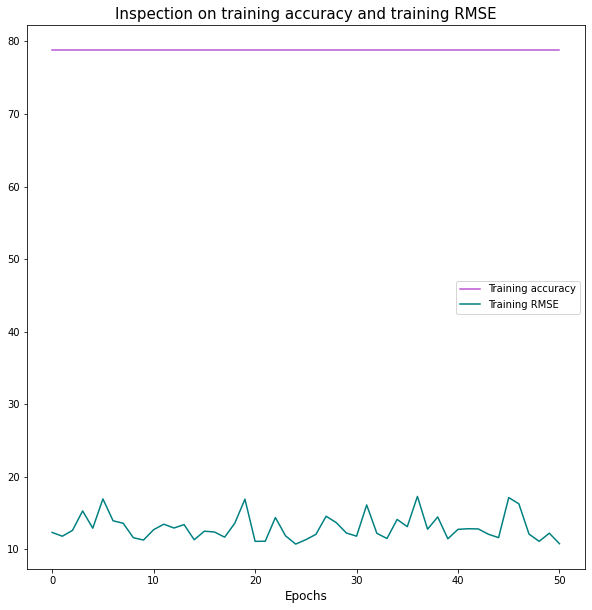

In [73]:
plt.figure(figsize=(10,10))

a = [history.history["accuracy"][i]*100 for i in range(len(history.history["accuracy"]))]
plt.plot(history.epoch, a, color="mediumorchid", label="Training accuracy")
plt.plot(history.epoch, history.history["root_mean_squared_error"], color="teal", label="Training RMSE")

plt.xlabel("Epochs", fontsize=12)
plt.title("Inspection on training accuracy and training RMSE", fontsize=15)
plt.legend(loc=7)

plt.show()

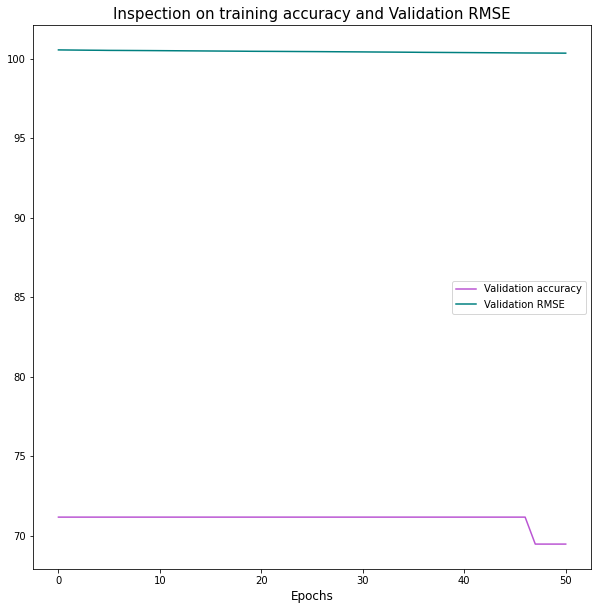

In [72]:
plt.figure(figsize=(10,10))

b = [history.history["val_accuracy"][i]*100 for i in range(len(history.history["val_accuracy"]))]
plt.plot(history.epoch, b, color="mediumorchid", label="Validation accuracy")
plt.plot(history.epoch, history.history["val_root_mean_squared_error"], color="teal", label="Validation RMSE")

plt.xlabel("Epochs", fontsize=12)
plt.title("Inspection on training accuracy and Validation RMSE", fontsize=15)
plt.legend(loc=7)

plt.show()

In [63]:
score = model.evaluate(train_X_scaled, train_Y, verbose=0)
accuracy_ANN = score[2] * 100
rmse_ANN = score[1]
print("Model Accuracy: {:.2f}%".format(accuracy_ANN))
print("RMSE value for ANN: {:.2f}".format(rmse_ANN))

Model Accuracy: 76.02%
RMSE value for ANN: 37.32


### **Linear Regression**

In [64]:
from sklearn.linear_model import LinearRegression

In [67]:
model_LR = LinearRegression().fit(train_X, train_Y)
pred_y = model_LR.predict(train_X)
rmse_LR = root_mean_squared_error(train_Y, pred_y)
accuracy_LR = model_LR.score(train_X, train_Y) * 100
print("Accuracy of Linear Regression model: {:.2f}%".format(accuracy_LR))
print("RMSE of Linear Regression model: {:.2f}".format(rmse_LR))

Accuracy of Linear Regression model: 19.35%
RMSE of Linear Regression model: 55.73


#### **Visualization of the analysis on the accuracy rate of different models**

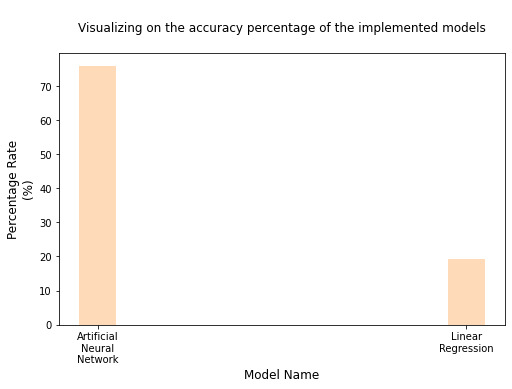

In [68]:
plt.figure(figsize=(8,5))

model_name = ["Artificial\nNeural\nNetwork", "Linear\nRegression"]
acc_list = [accuracy_ANN, accuracy_LR]

plt.bar(model_name, acc_list, width=0.1, color= "peachpuff")
plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Percentage Rate\n(%)", fontsize=12)
plt.title("\nVisualizing on the accuracy percentage of the implemented models\n", fontsize=12)
plt.show()

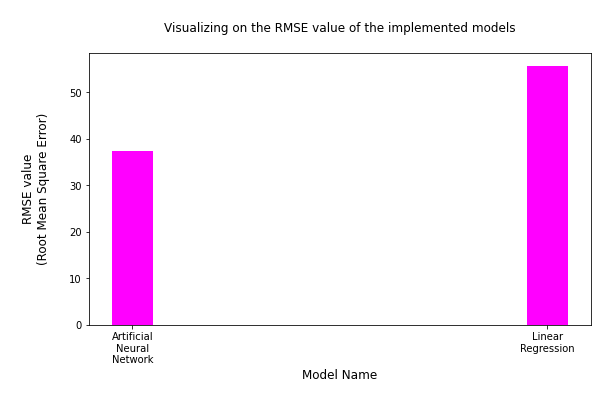

In [69]:
plt.figure(figsize=(9,5))

model_name = ["Artificial\nNeural\nNetwork", "Linear\nRegression"]
acc_list = [rmse_ANN, rmse_LR]

plt.bar(model_name, acc_list, width=0.1, color= "magenta")
plt.xlabel("Model Name\n", fontsize=12)
plt.ylabel("\nRMSE value\n(Root Mean Square Error)\n", fontsize=12)
plt.title("\nVisualizing on the RMSE value of the implemented models\n", fontsize=12)
plt.show()